In [36]:
# Author: Alexandre Gramfort <alexandre.gramfort@inria.fr>
# License: BSD 3 clause

print(__doc__)

import shutil
import tempfile

import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg, ndimage
from joblib import Memory

from sklearn.feature_extraction.image import grid_to_graph
from sklearn import feature_selection
from sklearn.cluster import FeatureAgglomeration
from sklearn.linear_model import BayesianRidge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

Automatically created module for IPython interactive environment


In [37]:
# #############################################################################
# Generate data
n_samples = 200
size = 40  # image size
roi_size = 15
snr = 5.
np.random.seed(0)
mask = np.ones([size, size], dtype=np.bool)
coef = np.zeros((size, size))
coef[0:roi_size, 0:roi_size] = -1.
coef[-roi_size:, -roi_size:] = 1.

In [38]:
mask.shape


(40, 40)

In [39]:
coef.shape, coef[:3], coef[-3:]

((40, 40),
 array([[-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         -1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         -1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         -1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.]]),
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.

In [40]:
X = np.random.randn(n_samples, size ** 2)

In [41]:
X.shape

(200, 1600)

In [42]:

for x in X:  # smooth data
    x[:] = ndimage.gaussian_filter(x.reshape(size, size), sigma=1.0).ravel()
X -= X.mean(axis=0)
X /= X.std(axis=0)

y = np.dot(X, coef.ravel())
noise = np.random.randn(y.shape[0])
noise_coef = (linalg.norm(y, 2) / np.exp(snr / 20.)) / linalg.norm(noise, 2)
y += noise_coef * noise  # add noise

In [43]:
X.shape, x.shape

((200, 1600), (1600,))

________________________________________________________________________________
[Memory] Calling sklearn.cluster.hierarchical.ward_tree...
ward_tree(array([[-0.451933, ..., -0.675318],
       ...,
       [ 0.275706, ..., -1.085711]]), 
<1600x1600 sparse matrix of type '<class 'numpy.int32'>'
	with 7840 stored elements in COOrdinate format>, n_clusters=None, return_distance=False)
________________________________________________________ward_tree - 0.3s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.cluster.hierarchical.ward_tree...
ward_tree(array([[ 0.905206, ...,  0.161245],
       ...,
       [-0.849835, ..., -1.091621]]), 
<1600x1600 sparse matrix of type '<class 'numpy.int32'>'
	with 7840 stored elements in COOrdinate format>, n_clusters=None, return_distance=False)
________________________________________________________ward_tree - 0.3s, 0.0min
______________________________________________________________________

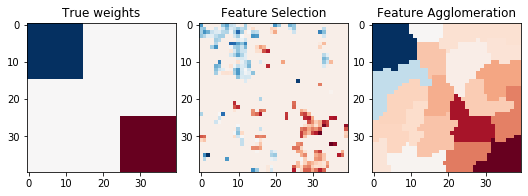

In [44]:
# #############################################################################
# Compute the coefs of a Bayesian Ridge with GridSearch
cv = KFold(2)  # cross-validation generator for model selection
ridge = BayesianRidge()
cachedir = tempfile.mkdtemp()
mem = Memory(location=cachedir, verbose=1)

# Ward agglomeration followed by BayesianRidge
connectivity = grid_to_graph(n_x=size, n_y=size)
ward = FeatureAgglomeration(n_clusters=10, connectivity=connectivity,
                            memory=mem)
clf = Pipeline([('ward', ward), ('ridge', ridge)])
# Select the optimal number of parcels with grid search
clf = GridSearchCV(clf, {'ward__n_clusters': [10, 20, 30]}, n_jobs=1, cv=cv)
clf.fit(X, y)  # set the best parameters
coef_ = clf.best_estimator_.steps[-1][1].coef_
coef_ = clf.best_estimator_.steps[0][1].inverse_transform(coef_)
coef_agglomeration_ = coef_.reshape(size, size)

# Anova univariate feature selection followed by BayesianRidge
f_regression = mem.cache(feature_selection.f_regression)  # caching function
anova = feature_selection.SelectPercentile(f_regression)
clf = Pipeline([('anova', anova), ('ridge', ridge)])
# Select the optimal percentage of features with grid search
clf = GridSearchCV(clf, {'anova__percentile': [5, 10, 20]}, cv=cv)
clf.fit(X, y)  # set the best parameters
coef_ = clf.best_estimator_.steps[-1][1].coef_
coef_ = clf.best_estimator_.steps[0][1].inverse_transform(coef_.reshape(1, -1))
coef_selection_ = coef_.reshape(size, size)

# #############################################################################
# Inverse the transformation to plot the results on an image
plt.close('all')
plt.figure(figsize=(7.3, 2.7))
plt.subplot(1, 3, 1)
plt.imshow(coef, interpolation="nearest", cmap=plt.cm.RdBu_r)
plt.title("True weights")
plt.subplot(1, 3, 2)
plt.imshow(coef_selection_, interpolation="nearest", cmap=plt.cm.RdBu_r)
plt.title("Feature Selection")
plt.subplot(1, 3, 3)
plt.imshow(coef_agglomeration_, interpolation="nearest", cmap=plt.cm.RdBu_r)
plt.title("Feature Agglomeration")
plt.subplots_adjust(0.04, 0.0, 0.98, 0.94, 0.16, 0.26)
plt.show()

# Attempt to remove the temporary cachedir, but don't worry if it fails
shutil.rmtree(cachedir, ignore_errors=True)

# Pipeline test 2 

In [45]:
import pandas as pd
winedf = pd.read_csv('winequality-red.csv', sep = ";")

In [46]:
winedf.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5


In [47]:
winedf.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

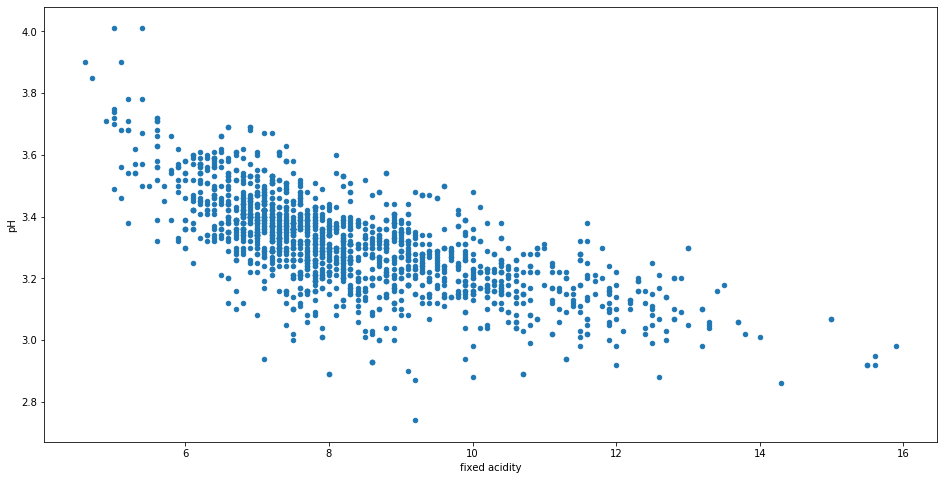

In [48]:
winedf.plot.scatter(x = "fixed acidity", y = "pH", figsize = (16, 8))

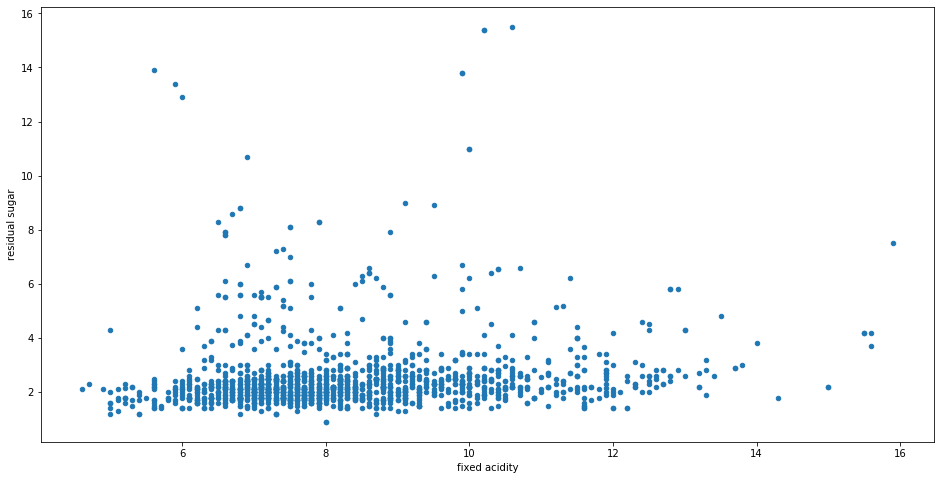

In [49]:
winedf.plot.scatter(x = "fixed acidity", y = "residual sugar", figsize = (16,8))

In [50]:
X = winedf.drop(['quality'], axis = 1)
Y = winedf["quality"]

In [51]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [52]:
steps = [ ('scaler', StandardScaler()), ('SVM', SVC())]

In [53]:
steps

[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('SVM', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
      kernel='rbf', max_iter=-1, probability=False, random_state=None,
      shrinking=True, tol=0.001, verbose=False))]

In [54]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps)

In [55]:
pipeline

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('SVM',
                 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [56]:
winedf.quality.value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [61]:
from sklearn.model_selection import train_test_split

In [62]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 30, stratify = Y)

In [63]:
X_test.shape, X_train.shape, Y_test.shape, Y_train.shape

((320, 11), (1279, 11), (320,), (1279,))

In [64]:
parameteres = {'SVM__C':[0.001,0.1,10,100,10e5], 'SVM__gamma':[0.1,0.01]}

In [65]:
from sklearn.model_selection import GridSearchCV

In [66]:
grid = GridSearchCV(pipeline, param_grid=parameteres, cv=5)

In [67]:
grid.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('SVM',
                                        SVC(C=1.0, cache_size=200,
                                            class_weight=None, coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='auto_deprecated',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None, shrinking=True,
                                            tol=0.001, verbose=False))],
                

In [68]:
grid

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('SVM',
                                        SVC(C=1.0, cache_size=200,
                                            class_weight=None, coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='auto_deprecated',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None, shrinking=True,
                                            tol=0.001, verbose=False))],
                

In [69]:
grid.best_params_

{'SVM__C': 10, 'SVM__gamma': 0.1}

In [ ]:
grid

# Pipeline 3 

In [70]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer

In [71]:
pipeline = Pipeline(steps = [
    ('vectorize', CountVectorizer()),
    ('classify', DecisionTreeClassifier())
])

In [72]:
raw_features = ['Hello world', 'Machine learning is awesome']
raw_labels = [0, 1]

pipeline.fit(raw_features, raw_labels)

Pipeline(memory=None,
         steps=[('vectorize',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('classify',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=None, max_features=None,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                     

In [76]:
sample_sentences = [ "Hi world", "Hi Valery", "Machine Learning is great"]
pipeline.predict(sample_sentences)

array([0, 0, 1])

# Specific Transformer 

In [77]:
from sklearn.base import TransformerMixin

In [78]:
class MyCustomStep(TransformerMixin):
    def transform(X, **kwargs):
        pass
    
    def fit(X, y=None, **kwargs):
        return self